<a href="https://colab.research.google.com/github/itzahs/SSL-for-RS/blob/main/03_ModelEvaluation_SSL4RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 **Semi-Supervised Learning for Remote Sensing (SSL4RS) Workshop** 🛰️

## 📂 Section 1 - Get Data & Software: Dataset Download & Augmentation
## 🛠️ Section 2 - Train Model: Implementing FixMatch Algorithm with PyTorch
## 📊 Section 3 - Model Evaluation: Analyzing Accuracy & Computational Cost from Log Files
## 📈 Section 4 - Model Inference: Inference with Trained Models & Confusion Matrix


### 📚 Setting Up the Working Folder & Importing Required Packages


In [ ]:
# Local modules
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set working folder as default
%cd "/content/drive/MyDrive/SSL4RS"

/content/drive/MyDrive/SSL4RS


In [ ]:
# Standard Library Imports
import os
import re
import requests
import zipfile
import shutil
from datetime import datetime

# Third-Party Imports
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate

### 📂 Downloading and Uploading Experiment Files

To initiate the experiment, we'll download the files

1. Download Experiment Files that are hosted in this link: [Experiment Files](https://drive.google.com/file/d/17Zcds1ld77x18xwCUEl3EK1a11ZMDg_s/view?usp=sharing).

2. Upload the files to the designated directory in your Google Drive:
     `/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results`

Your directory structure should now resemble the following:

| Classification-SemiCLS                 |
|----------------------------------------|
| results                                |
| ├ fm_ucm_wres_x2_b1x8_l840              |
|     └─── fm_ucm_wres_x2_b1x8_l840.log  |
|     └─── fm_ucm_wres_x2_b1x8_l840.tar  |
|     └─── fm_ucm_wres_x2_b1x8_l840.py   |

- The `.py` file represents the configuration file.
- The `.log` file contains the training output.
- The `.tar` file contains the trained model.

By following these steps, you'll have the necessary files in place to proceed with the model evaluation.



In [ ]:
# URL of the publicly shared .zip file
file_url = 'https://drive.google.com/uc?id=17Zcds1ld77x18xwCUEl3EK1a11ZMDg_s'

# Destination directory to extract the contents
destination_dir = '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results'

# Download the file
response = requests.get(file_url)

if response.status_code == 200:
    # Save the downloaded file
    with open('/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results/fm_ucm_wres_x2_b1x8_l840.zip', 'wb') as file:
        file.write(response.content)

    # Unzip the downloaded .zip file to the destination directory
    with zipfile.ZipFile('/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results/fm_ucm_wres_x2_b1x8_l840.zip', 'r') as zip_ref:
        zip_ref.extractall(destination_dir)

    print(f"File downloaded and extracted to '{destination_dir}'.")
else:
    print("Failed to download the file.")

# Checking that the data was correctly extracted
!ls '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results/fm_ucm_wres_x2_b1x8_l840'

File downloaded and extracted to '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results'.
fm_ucm_wres_x2_b1x8_l840.log  fm_ucm_wres_x2_b1x8_l840.tar
fm_ucm_wres_x2_b1x8_l840.py


In [ ]:
base_path = '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results'
evaluation_folder = base_path+'/fm_ucm_wres_x2_b1x8_l840'

# Evaluation outputs
# Path to save CSV for the extracted accuracies
accuracies_csv = base_path+'/accuracies.csv'
# Summary table with all the parameters
logs_info_csv = base_path+'/logs_info.csv'
# Summary table with the computational costs
computational_costs_csv = base_path+'/computational_costs.csv'

### 📊 Get Model Accuracy Metrics from the log file

- Top-1 Accuracy
- Top-5 Accuracy
- Best Top-1 Accuracy
- Mean Top-1 Accuracy

In [ ]:
def parse_log_files_in_folder(folder_path):
    parsed_metrics = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".log"):
            file_path = os.path.join(folder_path, file_name)
            log_content = ""

            with open(file_path, 'r', encoding='UTF-8') as log_file:
                log_content = log_file.read()

            # Patterns to find and extract numbers directly as integers or floats
            epoch = list(map(int, re.findall(r'Epoch (\d+)', log_content)))
            top1 = [(int(e), float(acc)) for e, acc in re.findall(r'Epoch (\d+) top-1 acc: (\d+\.\d+)', log_content)]
            top5 = [(int(e), float(acc)) for e, acc in re.findall(r'Epoch (\d+) top-5 acc: (\d+\.\d+)', log_content)]
            best_top1 = list(map(float, re.findall(r'Best top-1 acc: (\d+\.\d+)', log_content)))
            mean_top1 = list(map(float, re.findall(r'Mean top-1 acc: (\d+\.\d+)', log_content)))

            # Convert 'epoch' to a set to get unique values
            unique_epochs = sorted(set(epoch))

            # Create dictionaries
            top1_dict = {}
            top5_dict = {}
            best_top1_dict = {}
            mean_top1_dict = {}

            seen_epochs = set()  # Track seen epochs to consider only the first occurrence

            for e, acc in top1:
                if e not in seen_epochs:
                    top1_dict[e] = acc
                    seen_epochs.add(e)

            for e, acc in top5:
                if e not in seen_epochs:
                    top5_dict[e] = acc
                    seen_epochs.add(e)

            for idx in range(len(unique_epochs)):
                best_top1_dict[idx] = best_top1[idx]

            for idx in range(len(unique_epochs)):
                mean_top1_dict[idx] = mean_top1[idx]

            parsed_metrics[file_name] = {
                "top1": top1_dict,
                "top5": top5_dict,
                "best_top1": best_top1_dict,
                "mean_top1": mean_top1_dict
            }

    return parsed_metrics


parsed_data = parse_log_files_in_folder(evaluation_folder)

# Create lists to store data for each column
data = {metric_type: [] for metric_type in ['top1', 'top5', 'best_top1', 'mean_top1']}
log_names = []
epochs = []

# Iterate through the parsed data and populate the data lists
for log_name, metrics in parsed_data.items():
    for epoch in metrics['top1']:
        for metric_type in ['top1', 'top5', 'best_top1', 'mean_top1']:
            if epoch in metrics[metric_type]:
                data[metric_type].append(metrics[metric_type][epoch])
            else:
                data[metric_type].append(None)
        log_name_without_extension = log_name.split('.log')[0]
        log_names.append(log_name_without_extension)
        epochs.append(epoch)

# Create the DataFrame using pd.concat
df = pd.DataFrame(data)
df['Log Name'] = log_names
df['Epoch'] = epochs

# Save the DataFrame as a CSV file
df.to_csv(accuracies_csv, index=False)

# Display the DataFrame
df

,top1,top5,best_top1,mean_top1,Log Name,Epoch
0,10.10,None,10.10,10.10,fm_ucm_wres_x2_b1x8_l840,0
1,24.57,None,24.57,17.33,fm_ucm_wres_x2_b1x8_l840,1
2,41.52,None,41.52,25.40,fm_ucm_wres_x2_b1x8_l840,2
3,57.71,None,57.71,33.48,fm_ucm_wres_x2_b1x8_l840,3
4,68.00,None,68.00,40.38,fm_ucm_wres_x2_b1x8_l840,4
...,...,...,...,...,...,...
195,94.19,None,94.38,93.85,fm_ucm_wres_x2_b1x8_l840,195
196,94.10,None,94.38,93.86,fm_ucm_wres_x2_b1x8_l840,196
197,94.38,None,94.38,93.88,fm_ucm_wres_x2_b1x8_l840,197
198,94.00,None,94.38,93.88,fm_ucm_wres_x2_b1x8_l840,198


## Plotting Results to visualize the model's performance


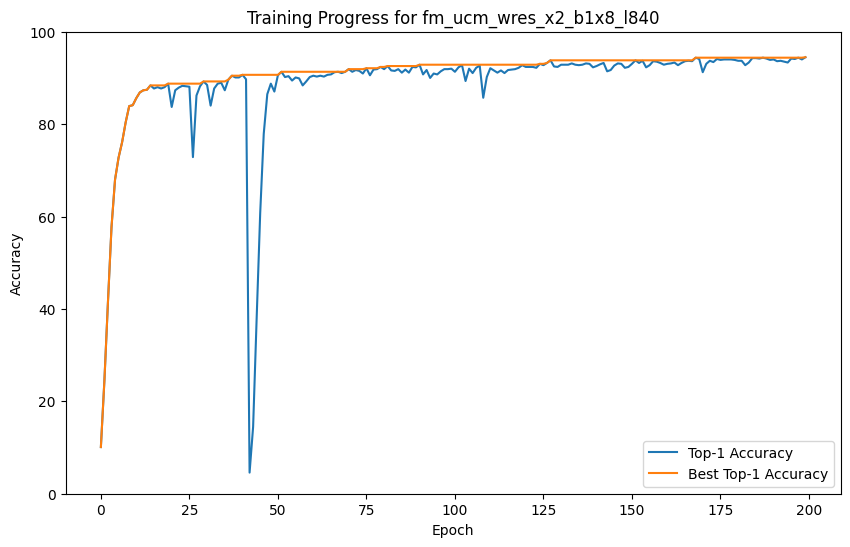

In [ ]:
def plot_training_progress(df, log_name, save_folder):
    selected_df = df[df['Log Name'] == log_name]

    plt.figure(figsize=(10, 6))

    plt.plot(selected_df['Epoch'], selected_df['top1'], label='Top-1 Accuracy')
    #plt.plot(selected_df['Epoch'], selected_df['top5'], label='Top-5 Accuracy')
    plt.plot(selected_df['Epoch'], selected_df['best_top1'], label='Best Top-1 Accuracy')
    #plt.plot(selected_df['Epoch'], selected_df['mean_top1'], label='Mean Top-1 Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100)  # Set y-axis limits between 0 and 100
    plt.title(f'Training Progress for {log_name}')
    plt.legend()
    plt.grid(False)

    # Save the figure as PNG in the specified folder
    save_path = f'{save_folder}/{log_name}_training_progress.png'
    plt.savefig(save_path)

    plt.show()

# Create a list of unique Log Names
unique_log_names = df['Log Name'].unique()

# Generate and display figures for each unique Log Name
for log_name in unique_log_names:
    plot_training_progress(df, log_name, base_path)

### 💻 Model Computational Cost Analysis

In this section, we'll assess the model's computational cost:

- Trainer, Model and Total Parameters
- Batch Size
- Training Duration
- Batch Processing Time

These metrics provide insights into the computational demands.

In [ ]:
def extract_info_from_log(file_path):
    # Regular expressions (regex) to extract information from the log
    variable_pattern = r"'(\w+)':\s*([\w.-]+)"                # Matches variable-value pairs
    time_pattern = r"(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2})"   # Matches timestamps
    model_info_pattern = r"(\w+)\s+Total params:\s*([\w.]+)"  # Matches model information
    trainer_pattern = r"'trainer': {'type': '(\w+)'"          # Matches trainer type
    data_info_pattern = r"'root':\s*'([^']*)'"                # Matches data root path

    # Open and read the log file
    with open(file_path, 'r') as log_file:
        log_content = log_file.read()

        # Extract various information using regular expressions
        variables = re.findall(variable_pattern, log_content)
        time_matches = re.findall(time_pattern, log_content)
        model_info_matches = re.findall(model_info_pattern, log_content)
        trainer_match = re.search(trainer_pattern, log_content)
        data_info_matches = re.search(data_info_pattern, log_content)

        # Convert extracted information into a dictionary
        variable_dict = dict(variables)

        # Extract and format model information
        if model_info_matches:
            model_name, total_params = model_info_matches[0]
            variable_dict['Model'] = model_name
            variable_dict['Total params'] = total_params

        # Adding training time to the variable_dict
        variable_dict['start_time'] = datetime.strptime(time_matches[0], '%m/%d/%Y %H:%M:%S')
        variable_dict['end_time'] = datetime.strptime(time_matches[-1], '%m/%d/%Y %H:%M:%S')
        variable_dict['training_time'] = variable_dict['end_time'] - variable_dict['start_time']
        training_hours = variable_dict['training_time'].days * 24 + variable_dict['training_time'].seconds // 3600
        training_minutes = (variable_dict['training_time'].seconds // 60) % 60
        variable_dict['training_time_hours'] = f"{training_hours:02d}:{training_minutes:02d}"

        # Extract and calculate average batch processing and data loading times
        batch_times = [float(batch_time) for _, _, _, _, _, batch_time, _ in re.findall(r"Train Epoch: (\d+)/\s*(\d+). Iter: (\d+)/(\d+). LR: ([\d.]+) batch_time: ([\d.]+) data_time: ([\d.]+)", log_content)]
        data_times = [float(data_time) for _, _, _, _, _, _, data_time in re.findall(r"Train Epoch: (\d+)/\s*(\d+). Iter: (\d+)/(\d+). LR: ([\d.]+) batch_time: ([\d.]+) data_time: ([\d.]+)", log_content)]

        avg_batch_times = sum(batch_times) / len(batch_times)
        avg_data_times = sum(data_times) / len(data_times)
        std_batch_times = np.std(batch_times)
        std_data_times = np.std(data_times)

        variable_dict['avg_batch_times'] = round(avg_batch_times, 4)
        variable_dict['std_batch_times'] = round(std_batch_times, 4)
        variable_dict['avg_data_times'] = round(avg_data_times, 4)
        variable_dict['std_data_times'] = round(std_data_times, 4)

        # Extract trainer type
        if trainer_match:
            variable_dict['Trainer'] = trainer_match.group(1)

        # Extract data information
        if data_info_matches:
          data_path = data_info_matches.group(1)
          data_parts = data_path.split('/')
        if len(data_parts) >= 2:
            data = data_parts[-2]  # Extract the second-to-last part after 'data/'
            variable_dict['Data'] = data

        combined_dict = variable_dict

    return combined_dict

# Create the table data
table_data = []

# Loop through the log files in the folder
for file_name in os.listdir(evaluation_folder):
    if file_name.endswith(".log"):
        file_path = os.path.join(evaluation_folder, file_name)

        # Extract information from the log file
        log_info = extract_info_from_log(file_path)

        # Convert boolean values to strings for tabulate
        log_info_str = {key: str(value) for key, value in log_info.items()}

        # Define the headers for the table
        if not table_data:  # Only define headers once
            headers = ["File"] + list(log_info_str.keys())

        # Append the log info to the table data with the file name as the first column
        table_data.append([file_name] + [str(log_info_str.get(key, "")) for key in headers[1:]])

# Convert table data to a DataFrame
df_logs = pd.DataFrame(table_data, columns=headers)

# Save the DataFrame as a CSV file
df_logs.to_csv(logs_info_csv, index=False)

# Print the DataFrame
df_logs


,File,gpu_id,pretrained,seed,use_BN,fp16,local_rank,no_progress,amp,total_steps,...,start_time,end_time,training_time,training_time_hours,avg_batch_times,std_batch_times,avg_data_times,std_data_times,Trainer,Data
0,fm_ucm_wres_x2_b1x8_l840.log,0,None,5,False,False,-1,False,False,204800,...,2023-01-05 17:21:16,2023-01-08 13:00:34,"2 days, 19:39:18",67:39,1.1858,0.0099,0.2314,0.009,FixMatch,UCM


### Table of Computational Cost Analysis

In [ ]:
# Selected columns - mu: ratio labeled to unlabeled
computational_costs = df_logs.loc[:, ['File','Trainer', 'Model', 'Total params', 'Data', 'num_classes', 'num_labeled', 'mu',  'batch_size', 'start_time', 'end_time', 'training_time', 'training_time_hours', 'avg_batch_times', 'avg_data_times']]

# Save to CSV
computational_costs.to_csv(computational_costs_csv)

# Show
computational_costs

,File,Trainer,Model,Total params,Data,num_classes,num_labeled,mu,batch_size,start_time,end_time,training_time,training_time_hours,avg_batch_times,avg_data_times
0,fm_ucm_wres_x2_b1x8_l840.log,FixMatch,wideresnet,1.47M,UCM,21,840,7,8,2023-01-05 17:21:16,2023-01-08 13:00:34,"2 days, 19:39:18",67:39,1.1858,0.2314
